# Decoder Only Transformer

In [ ]:
import torch
from torch import nn
import numpy as np
import torch.nn.functional as F
from tqdm import tqdm
import re
from nltk.corpus import stopwords
import gc
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader


stop=set(stopwords.words('english'))

batch_size = 32 # how many independent sequences will we process in parallel?
block_size = 512    # what is the maximum context length for predictions?
max_iters = 6000
eval_interval = 500
learning_rate = 3e-4
device = 'cuda:1' if torch.cuda.is_available() else 'cpu'
eval_iters = 500
n_embd = 256
n_head = 8
n_layer = 8
dropout = 0.1
weight_decay = 1e-1
beta1 = 0.9
beta2 = 0.95
epochs = 10
warmup_iters = 1500
learning_rate = 6e-4
lr_decay_iters = 6000
min_lr = 6e-5
torch.cuda.empty_cache()
gc.collect()

4591

# Data PreProcessing

In [143]:
data = ""
for i in tqdm(range(1,6)):
    with open(f"harry/{i}.txt", "r") as f:
        data += f.read()

data[:100]

100%|██████████| 5/5 [00:00<00:00, 772.15it/s]


'M r. and Mrs. Dursley, of number four, Privet Drive, were proud to say that they were perfectly norm'

## Tokenization

In [144]:
import tiktoken
enc = tiktoken.get_encoding("o200k_base")
assert enc.decode(enc.encode("hello world")) == "hello world"

enc = tiktoken.encoding_for_model("gpt2")
vocab_size = enc.n_vocab
encoded_data = enc.encode(data)
len(encoded_data)

1094434

In [146]:
data = torch.tensor(encoded_data, dtype=torch.long)
n = int(0.9*len(data)) # first 90% will be train, rest val
train_data = data[:n]
val_data = data[n:]

In [ ]:
# data loading
def get_batch(split):
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

In [ ]:
# # device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# train = torch.tensor(encoded_data[:int(len(encoded_data)*0.9)], dtype=torch.long)
# val = torch.tensor(encoded_data[int(len(encoded_data)*0.9):], dtype=torch.long)
# # train.to(device)
# # val.to(device)
# print(train.shape, val.shape)

# class TextDataSet(Dataset):
#     def __init__(self, tokens: list[int], sequence_size = block_size, stride = 1, device = 'cpu'):
#         # self._tokenizer = tokenizer
#         self._input_ids = []
#         self._target_ids = []

#         token_length = len(tokens)

#         for i in range(0, token_length - sequence_size, stride):
#             input_chunk = tokens[i:i + sequence_size]
#             target_chunk = tokens[i + 1: i + sequence_size + 1]

#             self._input_ids.append(torch.tensor(input_chunk)) # .to(device))
#             self._target_ids.append(torch.tensor(target_chunk)) #.to(device))

#     def __len__(self):
#         return len(self._input_ids)

#     def __getitem__(self, idx):
#         return self._input_ids[idx], self._target_ids[idx]
    

# text_data_set = TextDataSet(train, device=device)
# val_data_set = TextDataSet(val, device=device)

# training_data_loader = DataLoader(text_data_set, batch_size=batch_size, 
#                           shuffle=False, drop_last=True)
# validation_data_loader = DataLoader(val_data_set, batch_size=batch_size,
#                             shuffle=False, drop_last=True)

# Model Architecture

## Gelu Activation 

### Formulae
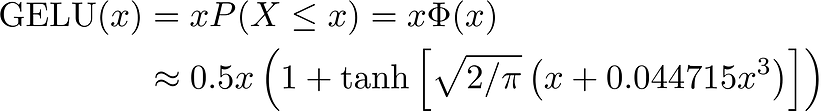

### Gelu Graph
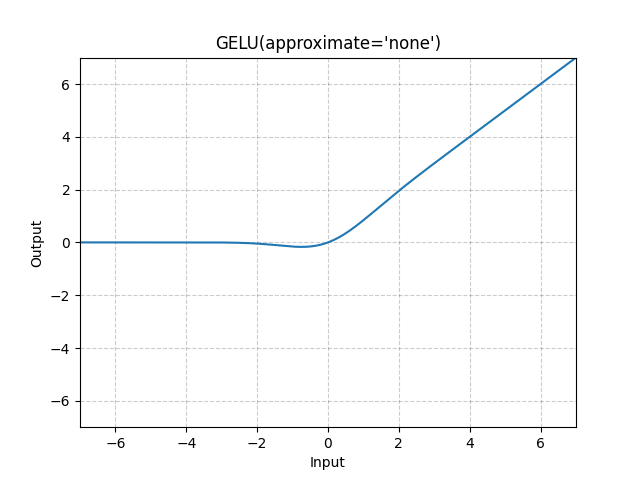

In [145]:
class Gelu(nn.Module):
    def forward(self, x):
        return 0.5*x*(1 + torch.tanh(np.sqrt(2/np.pi)*(x + 0.044715*torch.pow(x,3))))

## Loss Estimator for validation

In [149]:
@torch.no_grad()
def estimate_loss():
    out = {}
    m.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = m(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    m.train()
    return out

## Positional Embedding

In [150]:
class PositionalEncoding(nn.Module):
    def __init__(self,max_seq_len=block_size,d_model=n_embd) -> None:
        super(PositionalEncoding,self).__init__()
        self.d_model = d_model
        pos = torch.arange(0, max_seq_len,dtype = torch.float).unsqueeze(1)
        frequency = torch.pow(10000,-torch.arange(0,d_model,2,dtype = torch.float)/self.d_model)
        self.pe = torch.zeros((max_seq_len,d_model))
        self.pe[:,0::2] = torch.sin(pos * frequency)
        self.pe[:,1::2] = torch.cos(pos * frequency)
    def forward(self, x):
        batch_size, seq_len = x.size()
        # [batch_size = 128, seq_len = 30]
        return self.pe[:seq_len, :]

## Custom LayerNorm With Bias

In [151]:
# class LayerNorm(nn.Module):
#     def __init__(self, ndim, bias):
#         super().__init__()
#         self.weight = nn.Parameter(torch.ones(ndim))
#         self.bias = nn.Parameter(torch.zeros(ndim)) if bias else None

#     def forward(self, input):
#         return F.layer_norm(input, self.weight.shape, self.weight, self.bias, 1e-5)

## Multi-Head Self-Attention

In [152]:
import math
class Head(nn.Module):
    def __init__(self, head_size):
        super().__init__()
        # self.key = nn.Linear(n_embd, head_size)
        self.n_heads = n_head
        self.d_model = block_size
        # self.query = nn.Linear(n_embd, head_size)
        # self.value = nn.Linear(n_embd, head_size)
        self.out = nn.Linear(head_size, n_embd)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))
        self.attn_dropout = nn.Dropout(dropout)
        self.resid_dropout = nn.Dropout(dropout)
        self.c_proj = nn.Linear(n_embd, n_embd)
        self.c_attn = nn.Linear(n_embd, 3 * n_embd)
        self.register_buffer("bias", torch.tril(torch.ones(block_size, block_size))
                                        .view(1, 1, block_size, block_size))

    
    def forward(self, x):
        B, T, C = x.size() # batch size, sequence length, embedding dimensionality (n_embd)

        q, k, v  = self.c_attn(x).split(n_embd, dim=2)
        k = k.view(B, T, n_head, C // n_head).transpose(1, 2) # (B, nh, T, hs)
        q = q.view(B, T, n_head, C // n_head).transpose(1, 2) # (B, nh, T, hs)
        v = v.view(B, T, n_head, C // n_head).transpose(1, 2) # (B, nh, T, hs)

        # causal self-attention; Self-attend: (B, nh, T, hs) x (B, nh, hs, T) -> (B, nh, T, T)
        
        att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
        att = att.masked_fill(self.bias[:,:,:T,:T] == 0, float('-inf'))
        att = F.softmax(att, dim=-1)
        att = self.attn_dropout(att)
        y = att @ v 
        y = y.transpose(1, 2).contiguous().view(B, T, C) 

        y = self.resid_dropout(self.c_proj(y))
        return y
    


## Diffrential Transformer

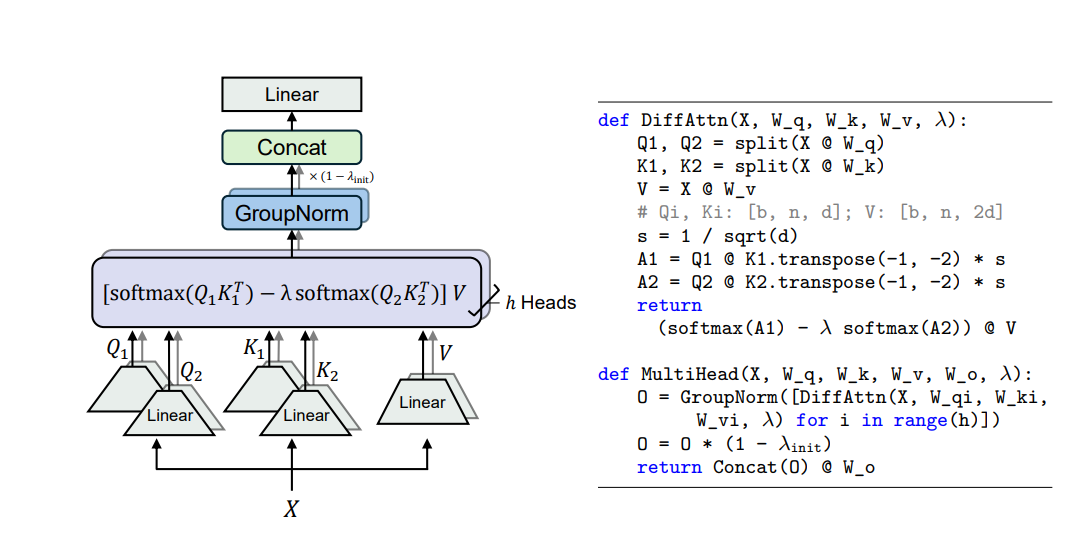

In [153]:
x = torch.randn(32, block_size, n_embd)

In [154]:
# import math

# def lambda_init_fn(depth=n_layer):
#     return 0.8 - 0.6 * math.exp(-0.3 * depth)

# class DiffAttn(nn.Module):
#     def __init__(self, head_size):
#         super().__init__()
#         self.key = nn.Linear(n_embd, head_size)
#         self.query = nn.Linear(n_embd, head_size)
#         self.value = nn.Linear(n_embd, head_size)
#         self.out = nn.Linear(head_size, n_embd)
#         self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))
#         self.dropout = nn.Dropout(dropout)
        
#     def forward(self, x, lam):
#         q1, q2 = torch.chunk(self.query(x), 2, dim=-1)
#         k1, k2 = torch.chunk(self.key(x), 2, dim=-1)
#         v = self.value(x)

#         s = 1/np.sqrt(n_embd/2)

#         a1 = (q1 @ k1.transpose(-2, -1)) * s
#         a2 = (q2 @ k2.transpose(-2, -1)) * s
#         # attn = attn.masked_fill(self.tril[:T, :T] == 0, float('-inf'))
#         # attn = attn.masked_fill(self.tril[:T, :T] == 0, float('-inf'))


#         return (F.softmax(a1, dim=-1) - lam * F.softmax(a2, dim=-1)) @ v 
    
# class MultiDiffAttn(nn.Module):
#     def __init__(self, head_size, n_heads):
#         super().__init__()
#         self.heads = nn.ModuleList([DiffAttn(head_size) for _ in range(n_heads)])
#         self.norm = nn.GroupNorm(n_heads, n_embd)
        
#     def forward(self, x, lam):
#         O = torch.cat([h(x, lam) for h in self.heads], dim=-1)
#         lam = lambda_init_fn()
#         O = O * (1 - lam)
#         return 
        


In [155]:
# import math
# import torch
# import torch.nn.functional as F
# from torch import nn

# from .kernel.rotary import apply_rotary_emb
# from flash_attn import flash_attn_func
# try:
#     from apex.normalization import FusedRMSNorm as RMSNorm 
# except ModuleNotFoundError:
#     print("No fused RMSNorm")
#     from .rms_norm import RMSNorm


# def repeat_kv(x: torch.Tensor, n_rep: int) -> torch.Tensor:
#     """torch.repeat_interleave(x, dim=1, repeats=n_rep)"""
#     bs, n_kv_heads, slen, head_dim = x.shape
#     if n_rep == 1:
#         return x
#     return (
#         x[:, :, None, :, :]
#         .expand(bs, n_kv_heads, n_rep, slen, head_dim)
#         .reshape(bs, n_kv_heads * n_rep, slen, head_dim)
#     )

# def lambda_init_fn(depth):
#     return 0.8 - 0.6 * math.exp(-0.3 * depth)


# class MultiheadDiffAttn(nn.Module):
#     def __init__(
#         self,
#         args,
#         embed_dim,
#         depth,
#         num_heads,
#     ):
#         super().__init__()
#         self.args = args
#         self.embed_dim = embed_dim
        
#         # arg num_heads set to half of Transformer's num_heads
#         self.num_heads = num_heads
        
#         # arg decoder_kv_attention_heads set to half of Transformer's num_kv_heads if use GQA
#         # set to same as num_heads if use normal MHA
#         self.num_kv_heads = args.decoder_kv_attention_heads if args.decoder_kv_attention_heads is not None else num_heads
#         self.n_rep = self.num_heads // self.num_kv_heads
        
#         self.head_dim = embed_dim // num_heads // 2
#         self.scaling = self.head_dim ** -0.5
        
#         self.q_proj = nn.Linear(embed_dim, embed_dim, bias=False)
#         self.k_proj = nn.Linear(embed_dim, embed_dim // self.n_rep, bias=False)
#         self.v_proj = nn.Linear(embed_dim, embed_dim // self.n_rep, bias=False)
#         self.out_proj = nn.Linear(embed_dim, embed_dim, bias=False)

#         self.lambda_init = lambda_init_fn(depth)
#         self.lambda_q1 = nn.Parameter(torch.zeros(self.head_dim, dtype=torch.float32).normal_(mean=0,std=0.1))
#         self.lambda_k1 = nn.Parameter(torch.zeros(self.head_dim, dtype=torch.float32).normal_(mean=0,std=0.1))
#         self.lambda_q2 = nn.Parameter(torch.zeros(self.head_dim, dtype=torch.float32).normal_(mean=0,std=0.1))
#         self.lambda_k2 = nn.Parameter(torch.zeros(self.head_dim, dtype=torch.float32).normal_(mean=0,std=0.1))

#         self.subln = RMSNorm(2 * self.head_dim, eps=1e-5, elementwise_affine=True)
    
#     def forward(
#         self,
#         x,
#         rel_pos,
#         attn_mask=None,
#     ):
#         bsz, tgt_len, embed_dim = x.size()
#         src_len = tgt_len

#         q = self.q_proj(x)
#         k = self.k_proj(x)
#         v = self.v_proj(x)

#         q = q.view(bsz, tgt_len, 2 * self.num_heads, self.head_dim)
#         k = k.view(bsz, src_len, 2 * self.num_kv_heads, self.head_dim)
#         v = v.view(bsz, src_len, self.num_kv_heads, 2 * self.head_dim)

#         q = apply_rotary_emb(q, *rel_pos, interleaved=True)
#         k = apply_rotary_emb(k, *rel_pos, interleaved=True)

#         offset = src_len - tgt_len
#         q = q.transpose(1, 2)
#         k = repeat_kv(k.transpose(1, 2), self.n_rep)
#         v = repeat_kv(v.transpose(1, 2), self.n_rep)
#         q *= self.scaling
#         attn_weights = torch.matmul(q, k.transpose(-1, -2))
#         if attn_mask is None:
#             attn_mask = torch.triu(
#                 torch.zeros([tgt_len, src_len])
#                 .float()
#                 .fill_(float("-inf"))
#                 .type_as(attn_weights),
#                 1 + offset,
#             )
#         attn_weights = torch.nan_to_num(attn_weights)
#         attn_weights += attn_mask   
#         attn_weights = F.softmax(attn_weights, dim=-1, dtype=torch.float32).type_as(
#             attn_weights
#         )

#         lambda_1 = torch.exp(torch.sum(self.lambda_q1 * self.lambda_k1, dim=-1).float()).type_as(q)
#         lambda_2 = torch.exp(torch.sum(self.lambda_q2 * self.lambda_k2, dim=-1).float()).type_as(q)
#         lambda_full = lambda_1 - lambda_2 + self.lambda_init
#         attn_weights = attn_weights.view(bsz, self.num_heads, 2, tgt_len, src_len)
#         attn_weights = attn_weights[:, :, 0] - lambda_full * attn_weights[:, :, 1]
        
#         attn = torch.matmul(attn_weights, v)
#         attn = self.subln(attn)
#         attn = attn * (1 - self.lambda_init)
#         attn = attn.transpose(1, 2).reshape(bsz, tgt_len, self.num_heads * 2 * self.head_dim)

#         attn = self.out_proj(attn)
#         return attn

In [156]:
# class MultiHeadAttention(nn.Module):
#     def __init__(self, num_heads, head_size):
#         super().__init__()
#         self.multi = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
#         self.out = nn.Linear(num_heads*head_size, n_embd)
#         self.dropout = nn.Dropout(dropout)

#     def forward(self, x):
#         out1 = torch.cat([m(x) for m in self.multi], dim=-1)
#         # out = torch.cat([h(x) for h in self.heads], dim=-1)
#         out = self.dropout(self.out(out1))
#         # out = self.dropGelu(self.out(out1))
#         return out

## FeedForward Neural Network Layer

In [157]:
class FeedForward(nn.Module):
    def __init__(self, n_embd):
        super().__init__()
        self.l1 = nn.Linear(n_embd, 4*n_embd)
        self.l2 = nn.Linear(4*n_embd, n_embd)
        self.dropout = nn.Dropout(dropout)
        self.dropGelu = Gelu()

    def forward(self, x):
        out = self.l1(x)
        out = self.dropGelu(out)
        # out = self.relu(out)
        out = self.l2(out)
        out = self.dropout(out)
        # out = self.dropGelu(out)
        return out

## One Block of Attention

In [158]:
class Block(nn.Module):
    def __init__(self, n_embd, n_head):
        super().__init__()
        self.d_k = n_embd//n_head
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)
        # self.mha = MultiHeadAttention(n_head, self.d_k)
        self.attn = Head(self.d_k)
        self.ff = FeedForward(n_embd)
    
    def forward(self, x):
        out = self.attn(self.ln1(x))
        out = out + x
        out = self.ff(self.ln2(out))
        out = out + x
        return out    

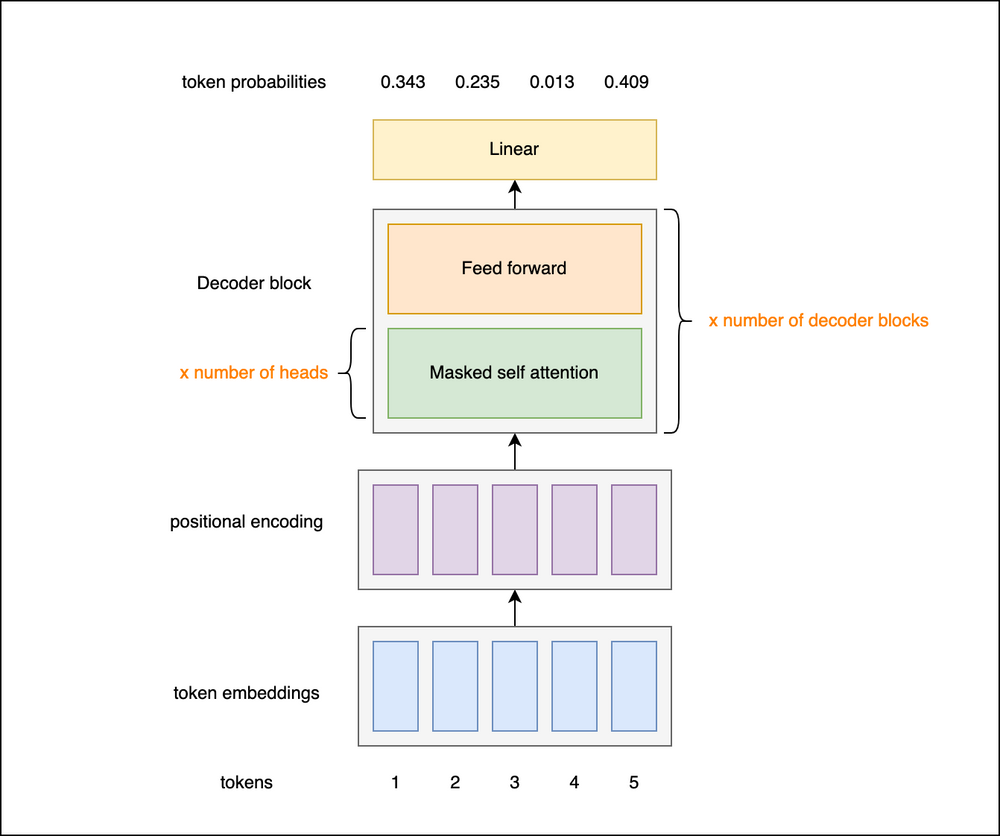

In [159]:
pos_embw = nn.Embedding(block_size, n_embd)
pos_emb = pos_embw(torch.arange(block_size))
pos_emb.shape

torch.Size([512, 256])

## Complete Class With all the Attentions Blocks 

In [160]:
import inspect
class GPTModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.tok_emb = nn.Embedding(vocab_size, n_embd)
        self.pos_emb = nn.Embedding(block_size, n_embd)
        self.pos_emb_2 = PositionalEncoding(block_size, n_embd)

        self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd) # final layer norm
        self.lm_head = nn.Linear(n_embd, vocab_size)

        self.apply(self._init_weights)
        for pn, p in self.named_parameters():
            if pn.endswith('c_proj.weight'):
                torch.nn.init.normal_(p, mean=0.0, std=0.02/math.sqrt(2 * n_layer))

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
        
    def forward(self, idx, targets=None):
        B, T = idx.shape

        # idx and targets are both (B,T) tensor of integers
        tok_emb = self.tok_emb(idx) # (B,T,C)
        # pos_emb = self.pos_emb(torch.arange(T, device=device)) # (T,C)
        pos_emb = self.pos_emb_2(idx).to(device) # (T,C)
        x = tok_emb + pos_emb # (B,T,C)
        x = self.blocks(x) # (B,T,C)
        x = self.ln_f(x) # (B,T,C)
        logits = self.lm_head(x) # (B,T,vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -block_size:]
            # get the predictions
            # print(idx_cond.shape)
            logits, loss = self(idx_cond)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx

    def configure_optimizers(self, weight_decay, learning_rate, betas, device_type):
        # start with all of the candidate parameters
        param_dict = {pn: p for pn, p in self.named_parameters()}
        # filter out those that do not require grad
        param_dict = {pn: p for pn, p in param_dict.items() if p.requires_grad}
        # create optim groups. Any parameters that is 2D will be weight decayed, otherwise no.
        # i.e. all weight tensors in matmuls + embeddings decay, all biases and layernorms don't.
        decay_params = [p for n, p in param_dict.items() if p.dim() >= 2]
        nodecay_params = [p for n, p in param_dict.items() if p.dim() < 2]
        optim_groups = [
            {'params': decay_params, 'weight_decay': weight_decay},
            {'params': nodecay_params, 'weight_decay': 0.0}
        ]
        num_decay_params = sum(p.numel() for p in decay_params)
        num_nodecay_params = sum(p.numel() for p in nodecay_params)
        print(f"num decayed parameter tensors: {len(decay_params)}, with {num_decay_params:,} parameters")
        print(f"num non-decayed parameter tensors: {len(nodecay_params)}, with {num_nodecay_params:,} parameters")
        # Create AdamW optimizer and use the fused version if it is available
        fused_available = 'fused' in inspect.signature(torch.optim.AdamW).parameters
        use_fused = fused_available and device_type == 'cuda'
        extra_args = dict(fused=True) if use_fused else dict()
        optimizer = torch.optim.AdamW(optim_groups, lr=learning_rate, betas=betas, **extra_args)
        print(f"using fused AdamW: {use_fused}")

        return optimizer

## Custom Learning Rate Iterator And dropper

In [161]:
def get_lr(it):
    # 1) linear warmup for warmup_iters steps
    if it < warmup_iters:
        return learning_rate * (it + 1) / (warmup_iters + 1)
    # 2) if it > lr_decay_iters, return min learning rate
    if it > lr_decay_iters:
        return min_lr
    # 3) in between, use cosine decay down to min learning rate
    decay_ratio = (it - warmup_iters) / (lr_decay_iters - warmup_iters)
    assert 0 <= decay_ratio <= 1
    coeff = 0.5 * (1.0 + math.cos(math.pi * decay_ratio)) # coeff ranges 0..1
    return min_lr + coeff * (learning_rate - min_lr)


# Training Loop

In [ ]:
import os
model = GPTModel()
m = model.to(device)
print(sum(p.numel() for p in m.parameters())/1e6, 'M parameters')
# learning_rate = 3e-4

optimizer = m.configure_optimizers(weight_decay, learning_rate, (beta1, beta2), device_type=device)
checkpoint = None # free up memory

for iter in tqdm(range(max_iters)):
    lr = get_lr(iter)
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

    if iter % eval_interval == 0 or iter == max_iters - 1:
        losses = estimate_loss()
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")
        print(f"lr {optimizer.param_groups[0]['lr']:.2E}")

    # scheduler.step(loss)
    # sample a batch of data
    xb, yb = get_batch('train')

    # evaluate the loss
    logits, loss = m(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    nn.utils.clip_grad_norm_(m.parameters(),1)
    optimizer.step()
    if iter % 1000 == 0:
        if os.path.exists('model.pth'):
            torch.save(m.state_dict(), 'model_3.pth')
        else:
            torch.save(m.state_dict(), 'model.pth')
    torch.cuda.empty_cache()

32.299089 M parameters
num decayed parameter tensors: 43, with 32,219,648 parameters
num non-decayed parameter tensors: 75, with 79,441 parameters
using fused AdamW: False


  0%|          | 0/6000 [00:00<?, ?it/s]

step 0: train loss 10.8731, val loss 10.8713
lr 1.20E-06


  8%|▊         | 500/6000 [06:08<51:57,  1.76it/s]  

step 500: train loss 4.9713, val loss 5.5538
lr 6.00E-04


 17%|█▋        | 1000/6000 [12:14<47:25,  1.76it/s]  

step 1000: train loss 4.0342, val loss 4.8087
lr 5.89E-04


 25%|██▌       | 1500/6000 [18:25<43:19,  1.73it/s]   

step 1500: train loss 3.5815, val loss 4.5376
lr 5.57E-04


 33%|███▎      | 2000/6000 [24:33<38:12,  1.74it/s]   

step 2000: train loss 3.2426, val loss 4.4161
lr 5.07E-04


 42%|████▏     | 2500/6000 [30:46<33:11,  1.76it/s]   

step 2500: train loss 2.9541, val loss 4.3674
lr 4.42E-04


 50%|█████     | 3000/6000 [36:54<29:03,  1.72it/s]   

step 3000: train loss 2.6979, val loss 4.3811
lr 3.68E-04


 58%|█████▊    | 3500/6000 [43:04<23:41,  1.76it/s]   

step 3500: train loss 2.4805, val loss 4.4120
lr 2.92E-04


 67%|██████▋   | 4000/6000 [49:12<18:55,  1.76it/s]   

step 4000: train loss 2.3074, val loss 4.4584
lr 2.18E-04


 75%|███████▌  | 4500/6000 [55:20<14:14,  1.76it/s]   

step 4500: train loss 2.1688, val loss 4.4990
lr 1.53E-04


 83%|████████▎ | 5000/6000 [1:01:28<09:24,  1.77it/s] 

step 5000: train loss 2.0668, val loss 4.5460
lr 1.03E-04


 92%|█████████▏| 5500/6000 [1:07:37<04:43,  1.77it/s]  

step 5500: train loss 1.9961, val loss 4.5682
lr 7.09E-05


100%|█████████▉| 5999/6000 [1:13:46<00:00,  1.74it/s]  

step 5999: train loss 1.9427, val loss 4.5873
lr 6.00E-05


100%|██████████| 6000/6000 [1:15:06<00:00,  1.33it/s]


## Testing with trained Model

In [166]:
context = torch.zeros((1, 1), dtype=torch.long, device=device)
print(enc.decode(m.generate(context, max_new_tokens=256)[0].tolist()))

! The def ignoring you dragged Peter in their dormitory. Have you do.”

Harry did something to him; he knew Dumbledore was being caught, but before he could catch it. But there was something quiet and after the girls in Herbology with Karkaroff, just as Krum had saved him an event. He paused, apparently alone were all on having a while, just for the fact, outnumbered by the entire school was Stan Shrusted in semidarkaroff, who had noticed a happily cut between off and swirling heavy hair.

“I will find them over there for a step now,” he said, offering it out his back. “On Monday night does not touch the idiot step, Mr. Bagman will insist upon unless it was!”

“I think your father might go back,” grunted Bagman, who still staring at him. “Killed him with my master, though I can clear that you do with it? Does the Dark Lord might want you were to know that he was supposed to be some house-elf sentence for him as wizards. I have spent a watch. I used you in there.”

'We'd have been


In [167]:
context

tensor([[0]], device='cuda:1')

In [171]:
q = "Harry was a wizard who lived in a house with his friends Ron and Hermione. He went to a school called Hogwarts where he learned magic. He had a pet owl named Hedwig. One day he was playing quiditch"
token = torch.tensor(enc.encode(q)).unsqueeze(0).to(device)
print(token)
print(enc.decode(m.generate(token, max_new_tokens=256)[0].tolist()))

tensor([[18308,   373,   257, 18731,   508,  5615,   287,   257,  2156,   351,
           465,  2460,  6575,   290, 19959,    13,   679,  1816,   284,   257,
          1524,  1444, 30922,   810,   339,  4499,  5536,    13,   679,   550,
           257,  4273, 39610,  3706, 30920, 28033,    13,  1881,  1110,   339,
           373,  2712,   627,   312,  2007]], device='cuda:1')
Harry was a wizard who lived in a house with his friends Ron and Hermione. He went to a school called Hogwarts where he learned magic. He had a pet owl named Hedwig. One day he was playing quiditch for Mr and and Mrs Weasley would almost blow in on the seventh floor, and would have made much more of a kind compared to how much longer than the first time to goaway or wanted an exhibition of spellbooks. Harry felt a slight feeling of shame. He didn't fly much at all right so quickly, and thought bitterly that Mr. Weasley was Captain without a cause for any more words, he needed to be poisonous, and his fellow entran